### Data Exploration

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [2]:
# Load the dataset to inspect its structure
tweet_data = pd.read_csv('./data_file/tweet_sentiments.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataset
tweet_data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The dataset consists of the following key columns:

* `tweet_text`: The actual text of the Tweet.
* `emotion_in_tweet_is_directed_at`: The product or brand mentioned in the Tweet (e.g., iPhone, iPad, Google).
* `is_there_an_emotion_directed_at_a_brand_or_product`: The sentiment or emotion expressed in the Tweet (e.g., Positive emotion, Negative emotion).

In [3]:
# Get a summary of the dataset, including data types and non-null counts
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The dataset information:

- The dataset contains **9,093 entries** and **3 columns**.
- All the columns are of the data type **object** (textual data).
- The dataset has some missing values in the `tweet_text` and `emotion_in_tweet_is_directed_at` columns.

In [4]:
# Display a summary of the missing values
tweet_data.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

The missing values in the dataset:

- `tweet_text`: 1 missing value. We will drop the row containing the missing text. 
- `emotion_in_tweet_is_directed_at`: 5802 missing values - could suggest that for many tweets, the emotion is not directed at a specific brand or product.  We will thus drop this column because it is not crucial for sentiment classification as our primary target is the sentiment. It is also not rational to fill in all the missing values with mean, median or mode for this column.
- `is_there_an_emotion_directed_at_a_brand_or_product`: 0 missing values.

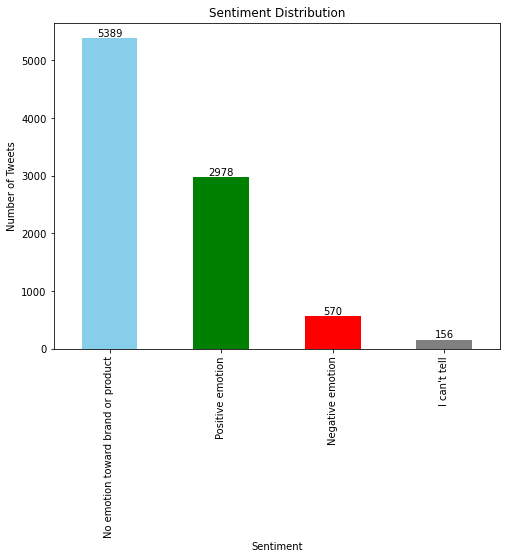

In [5]:
# Check the distribution of the sentiment
sentiment_distribution = tweet_data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
ax = sentiment_distribution.plot(kind='bar', color=['skyblue', 'green', 'red', 'gray'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=90)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

The sentiment distribution shows a significant imbalance that needs to be addressed during pre-processing through appropriate methods. Majority of the tweets (5,389) have no emotion directed at a brand or product, while positive emotions (2,978) are significantly more represented than negative emotions (570). 156 instances are labeled as "I can't tell" which we could remove or filter out.

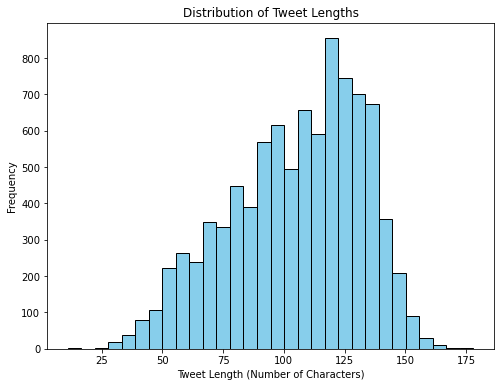

In [6]:
# Analyze the text length by calculating the number of characters in each tweet
tweet_lengths = tweet_data['tweet_text'].str.len()

# Plot the distribution of tweet lengths
plt.figure(figsize=(8, 6))
plt.hist(tweet_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

Most tweets appear to fall within a moderate length range, with the majority clustered between shorter lengths (as expected with tweet constraints). Since the dataset is not too huge, we will not truncate the tweets during tokenization.

In [7]:
# Count common words in the tweet_text
# Clean the tweet_text by dropping rows with missing text values
tweet_data_cleaned = tweet_data.dropna(subset=['tweet_text'])

# Tokenize the cleaned tweets by sentiment
positive_tweets = tweet_data_cleaned[tweet_data_cleaned['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']['tweet_text'].str.split()
negative_tweets = tweet_data_cleaned[tweet_data_cleaned['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']['tweet_text'].str.split()
neutral_tweets = tweet_data_cleaned[tweet_data_cleaned['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']['tweet_text'].str.split()

# Flatten the tokenized tweets into a single list per sentiment
positive_words = [word.lower() for tweet in positive_tweets for word in tweet if word]
negative_words = [word.lower() for tweet in negative_tweets for word in tweet if word]
neutral_words = [word.lower() for tweet in neutral_tweets for word in tweet if word]

# Count the most common words in each sentiment
positive_common_words = Counter(positive_words).most_common(10)
negative_common_words = Counter(negative_words).most_common(10)
neutral_common_words = Counter(neutral_words).most_common(10)

positive_common_words, negative_common_words, neutral_common_words

([('#sxsw', 2506),
  ('@mention', 2062),
  ('the', 1578),
  ('{link}', 1202),
  ('to', 1146),
  ('at', 999),
  ('rt', 913),
  ('for', 904),
  ('ipad', 793),
  ('a', 777)],
 [('#sxsw', 512),
  ('the', 300),
  ('@mention', 292),
  ('to', 255),
  ('is', 159),
  ('a', 151),
  ('ipad', 140),
  ('at', 137),
  ('rt', 137),
  ('of', 131)],
 [('#sxsw', 4680),
  ('@mention', 4249),
  ('{link}', 2904),
  ('the', 2409),
  ('to', 2112),
  ('at', 1868),
  ('rt', 1814),
  ('for', 1474),
  ('a', 1281),
  ('google', 1187)])

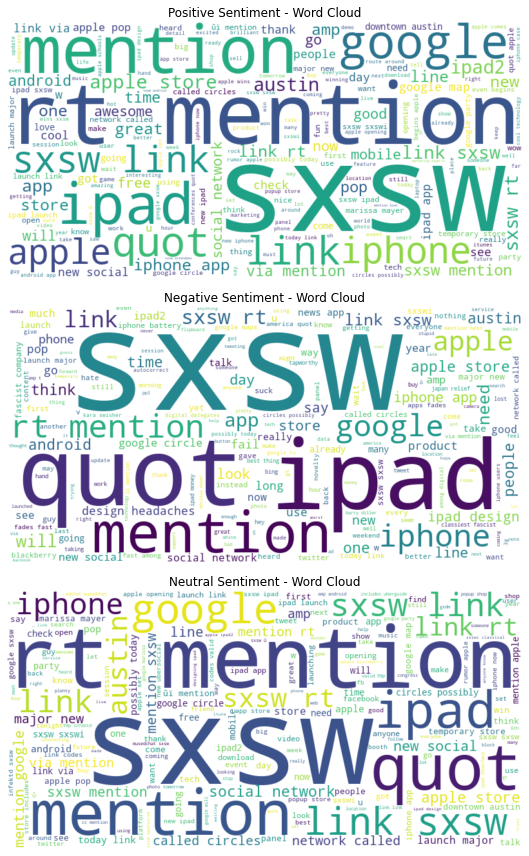

In [8]:
# Generate word clouds for each sentiment category
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_words))
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(neutral_words))

# Plot the word clouds for each sentiment
plt.figure(figsize=(16, 12))

# Positive sentiment word cloud
plt.subplot(3, 1, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment - Word Cloud')

# Negative sentiment word cloud
plt.subplot(3, 1, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment - Word Cloud')

# Neutral sentiment word cloud
plt.subplot(3, 1, 3)
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Sentiment - Word Cloud')

plt.tight_layout()
plt.show()

The word clouds reveal that event-related terms like "SXSW", "mention", and "link" dominate across all sentiment categories, indicating that the dataset contains many tweets focused on the SXSW event rather than expressing sentiment. Product-related terms like "iPhone", "iPad", and "Google" are also frequent, but sentiment-specific words are limited. This suggests that pre-processing adjustments, such as removing non-informative terms (e.g., mentions, links, hashtags) and refining the handling of product-specific words, could help improve sentiment analysis.

### Data Preparation

In [9]:
# Clean the data
# Drop rows with missing tweet_text and drop the column 'emotion_in_tweet_is_directed_at' as it is not necessary for sentiment analysis
cleaned_tweet_data = tweet_data.dropna(subset=['tweet_text']).drop(columns=['emotion_in_tweet_is_directed_at'])

# Display the cleaned dataset for further inspection
cleaned_tweet_data.head()

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [10]:
# Cross-checking that there are no missing values
missing_values = cleaned_tweet_data.isnull().sum()

missing_values

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

The dataset has been successfully cleaned by removing the missing entries from the `tweet_text` column and dropping the irrelevant `emotion_in_tweet_is_directed_at` column.

In [11]:
# Perform text-processing
# Import necessary libraries for text preprocessing
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function for text preprocessing
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply the preprocessing function to the 'tweet_text' column
cleaned_tweet_data['cleaned_text'] = cleaned_tweet_data['tweet_text'].apply(preprocess_text)

# Display the first few rows of the preprocessed data
cleaned_tweet_data[['tweet_text', 'cleaned_text']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\engig\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\engig\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\engig\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,wesley g iphone hr tweeting riseaustin dead ne...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,jessedee know fludapp awesome ipadiphone app y...
2,@swonderlin Can not wait for #iPad 2 also. The...,swonderlin wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,sxsw hope year festival isnt crashy year iphon...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,sxtxstate great stuff fri sxsw marissa mayer g...


The `cleaned_text` column now contains preprocessed Tweet text, which has been:

* Converted to lowercase.
* Stripped of punctuation and special characters.
* Tokenized, with stop words removed.
* Lemmatized to reduce words to their base form.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Perform feature engineering
# Filter the dataset for only positive and negative sentiments
binary_data = cleaned_tweet_data[cleaned_tweet_data['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['Positive emotion', 'Negative emotion'])]

# Prepare target variable (1 for positive, 0 for negative)
y_binary = binary_data['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else 0)

# Split the binary dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(binary_data['tweet_text'], y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Define the TF-IDF Vectorizer with a maximum of 5000 features and stop words removed
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training text data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same TF-IDF model
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

# Display the shapes of the resulting SMOTE-applied data
(X_train_smote.shape, y_train_smote.shape)

((4764, 5000), (4764,))

The dataset is prepared for binary sentiment analysis by filtering for only positive and negative sentiments. The target variable is created by labeling positive emotions as 1 and negative emotions as 0. The data is then split into training and test sets using an 80/20 ratio. The text data is transformed using a TF-IDF vectorizer, which converts the text into numerical features with a maximum of 5,000 features. Finally, SMOTE (Synthetic Minority Over-sampling Technique) is applied to the training data to address class imbalance, ensuring that both sentiment classes are more equally represented during model training.

## Modeling

### 1. Binary Classification

#### 1a. Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV


# Define the hyperparameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Penalty norm (L1 norm is typically supported with 'liblinear' or 'saga')
    'solver': ['liblinear', 'saga']  # Solvers compatible with penalty
}

# Initialize the Logistic Regression model
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)

# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

# Fit the GridSearchCV to the SMOTE-balanced training data
grid_search.fit(X_train_smote, y_train_smote)

# Display the best hyperparameters found
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best model found by GridSearchCV
best_logreg = grid_search.best_estimator_
y_pred_best = best_logreg.predict(X_test_tfidf)

# Evaluate the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_best)
report_tuned = classification_report(y_test, y_pred_best, target_names=['Negative', 'Positive'])

# Display the evaluation scores
print(f"Accuracy after Tuning: {accuracy_tuned}")
print("Classification Report after Tuning:\n", report_tuned)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy after Tuning: 0.8816901408450705
Classification Report after Tuning:
               precision    recall  f1-score   support

    Negative       0.64      0.61      0.62       114
    Positive       0.93      0.93      0.93       596

    accuracy                           0.88       710
   macro avg       0.78      0.77      0.78       710
weighted avg       0.88      0.88      0.88       710



Results for the binary classification task with a tuned logistic regression model:

* **Accuracy:** 88%  
  The model shows a strong overall accuracy of 88%, meaning it correctly classifies a large majority of the tweets. However, this metric could be influenced by the class imbalance, where positive tweets dominate the dataset.

* **Negative Class (Precision: 0.64, Recall: 0.61, F1-score: 0.62):**  
  The model performs moderately well at predicting negative sentiment. A precision of 0.64 indicates that 64% of the predicted negative sentiments are correct, while a recall of 0.61 means the model captures 61% of all actual negative sentiments. The F1-score of 0.62 suggests a fair balance between precision and recall, but there’s room for improvement, especially in recall, to ensure more negative cases are correctly identified.

* **Positive Class (Precision: 0.93, Recall: 0.93, F1-score: 0.93):**  
  The model excels at classifying positive sentiment, with both precision and recall at 0.93. This shows that the model is highly effective at identifying positive tweets and has very few false positives or missed positive cases. The high F1-score of 0.93 confirms the model's consistency and reliability in identifying positive sentiment. 

Overall, while the model performs very well with positive sentiment, improving the recall for the negative class could enhance its overall performance.

#### 1b. Random Forest

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required to be at a leaf node
    'max_features': ['auto', 'sqrt']   # Number of features to consider at each split
}

# Initialize the Random Forest model
rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42)

# Set up GridSearchCV with 3-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

# Fit the GridSearchCV to the SMOTE-balanced training data
grid_search_rf.fit(X_train_smote, y_train_smote)

# Display the best hyperparameters found
best_params_rf = grid_search_rf.best_params_
print(f"Best Parameters: {best_params_rf}")

# Train the best model found by GridSearchCV
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_tfidf)

# Evaluate the tuned model
accuracy_tuned_rf = accuracy_score(y_test, y_pred_best_rf)
report_tuned_rf = classification_report(y_test, y_pred_best_rf, target_names=['Negative', 'Positive'])

# Display the evaluation scores
print(f"Accuracy after Tuning: {accuracy_tuned_rf}")
print("Classification Report after Tuning:\n", report_tuned_rf)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy after Tuning: 0.8816901408450705
Classification Report after Tuning:
               precision    recall  f1-score   support

    Negative       0.79      0.36      0.49       114
    Positive       0.89      0.98      0.93       596

    accuracy                           0.88       710
   macro avg       0.84      0.67      0.71       710
weighted avg       0.87      0.88      0.86       710

